In [1]:
# import library
import zipfile,os
import splitfolders as sf
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image

In [2]:
# extract dataset zip file
local_zip = 'dataset.zip' # dataset file name and path
zip_ref = zipfile.ZipFile(local_zip, 'r') # read zip file
zip_ref.extractall('tmp') # extract to temporary folder
zip_ref.close()

In [3]:
# split dataset into train (80%) and validation (20%) with split_folders
sf.ratio('tmp', output="dataset", seed=1337, ratio=(.8, .2))
# make directory for data train dan data test
base_dir='dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [4]:
os.listdir('dataset')

['train', 'val']

In [5]:
os.listdir('dataset/train')
os.listdir('dataset/val')

['paper', 'rock', 'scissors']

In [6]:
print('total Train images :', len(os.listdir('dataset/train/paper')) + len(os.listdir('dataset/train/rock')) + len(os.listdir('dataset/train/scissors')))
print('total Validation images :', len(os.listdir('dataset/val/paper')) + len(os.listdir('dataset/val/rock')) + len(os.listdir('dataset/val/scissors')))

total Train images : 1749
total Validation images : 439


In [7]:
train_rock_dir = os.path.join(train_dir, 'rock')  # directory data train for rock image
train_paper_dir = os.path.join(train_dir, 'paper') # directory data train for paper image
train_scissors_dir = os.path.join(train_dir, 'scissors')  # directory data train for scissor image
val_rock_dir = os.path.join(val_dir, 'rock') # directory data validation for rock image
val_paper_dir = os.path.join(val_dir, 'paper') # directory data validation for paper image
val_scissors_dir = os.path.join(val_dir, 'scissors') # directory data validation for scissor image

In [8]:
print('total Paper images :', len(os.listdir(train_paper_dir)) + len(os.listdir(val_paper_dir)))
print('total Rock images :', len(os.listdir(train_rock_dir)) + len(os.listdir(val_rock_dir)))
print('total Scissors images :', len(os.listdir(train_scissors_dir)) + len(os.listdir(val_scissors_dir)))

total Paper images : 712
total Rock images : 726
total Scissors images : 750


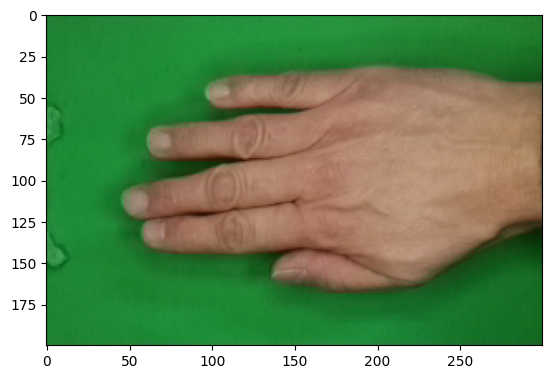

In [9]:
# show one sample image
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
img = image.load_img(train_paper_dir+'/BfFGJgByTJnxADwA.png')
imgplot = plt.imshow(img)

In [10]:
# make ImageDataGenerator object for data train and data test
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [11]:
# prepare data train
train_generator = train_datagen.flow_from_directory(
        train_dir, # directory data train
        target_size=(180, 180), # change all of the image resolution into 180x180 pixel
        batch_size=16, # batch size
        shuffle=True, # randomize data
        # use 'sparse' for multiclass classification
        class_mode='sparse')
# prepare data test
validation_generator = test_datagen.flow_from_directory(
        val_dir, # directory data validation
        target_size=(180, 180), # change all of the image resolution into 200x200 pixel
        batch_size=16, # batch size
        shuffle=True, # randomize data
        # use 'sparse' for multiclass classification
        class_mode='sparse')

Found 1749 images belonging to 3 classes.
Found 439 images belonging to 3 classes.


In [12]:
# make CNN model for image processing
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(180, 180, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu',
                          kernel_regularizer=regularizers.l2(0.0001),
                          bias_regularizer=regularizers.l1(0.0001),
                          activity_regularizer=regularizers.l1_l2(0.0001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu',
                          kernel_regularizer=regularizers.l2(0.0001),
                          bias_regularizer=regularizers.l1(0.0001),
                          activity_regularizer=regularizers.l1_l2(0.0001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu',
                          kernel_regularizer=regularizers.l2(0.0001),
                          bias_regularizer=regularizers.l1(0.0001),
                          activity_regularizer=regularizers.l1_l2(0.0001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])
# use 3 hidden layer, dropout=0.2, and regularizers function

c:\Users\dzulf\OneDrive\Documents\GitHub\Images-Classification\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [13]:
model.compile(loss='sparse_categorical_crossentropy', 
              # use 'sparse_categorical_crossentropy' loss function for multiclass classification 
              optimizer=tf.keras.optimizers.RMSprop(
                  learning_rate=0.0001, rho=0.8, momentum=0.0, epsilon=1e-07, centered=True,
                  name='RMSprop'
              ),
              # use RMSprop optimizer
              metrics=['accuracy'])

In [14]:
# train the model
history = model.fit(
      train_generator,
      steps_per_epoch=35,  # batch size for each epoch
      epochs=25, # number of epoch
      validation_data=validation_generator, # show data validation accuracy
      validation_steps=5,  # batch size for each epoch
      verbose=2)

Epoch 1/25


c:\Users\dzulf\OneDrive\Documents\GitHub\Images-Classification\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 - 53s - 2s/step - accuracy: 0.3714 - loss: 1.3056 - val_accuracy: 0.3750 - val_loss: 1.2976
Epoch 2/25
35/35 - 48s - 1s/step - accuracy: 0.3661 - loss: 1.2974 - val_accuracy: 0.7250 - val_loss: 1.2943
Epoch 3/25
35/35 - 37s - 1s/step - accuracy: 0.5464 - loss: 1.2922 - val_accuracy: 0.7625 - val_loss: 1.2845
Epoch 4/25


C:\Users\dzulf\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


35/35 - 6s - 158ms/step - accuracy: 0.6500 - loss: 1.2835 - val_accuracy: 0.5875 - val_loss: 1.2869
Epoch 5/25
35/35 - 42s - 1s/step - accuracy: 0.6357 - loss: 1.2601 - val_accuracy: 0.8625 - val_loss: 1.1844
Epoch 6/25
35/35 - 29s - 829ms/step - accuracy: 0.7596 - loss: 1.0632 - val_accuracy: 0.7949 - val_loss: 0.8892
Epoch 7/25
35/35 - 45s - 1s/step - accuracy: 0.8054 - loss: 0.8935 - val_accuracy: 0.8375 - val_loss: 0.7698
Epoch 8/25
35/35 - 9s - 264ms/step - accuracy: 0.8000 - loss: 0.8452 - val_accuracy: 0.8500 - val_loss: 0.7658
Epoch 9/25
35/35 - 47s - 1s/step - accuracy: 0.8482 - loss: 0.7836 - val_accuracy: 0.9000 - val_loss: 0.7041
Epoch 10/25
35/35 - 33s - 957ms/step - accuracy: 0.8634 - loss: 0.7059 - val_accuracy: 0.8250 - val_loss: 0.7505
Epoch 11/25
35/35 - 32s - 906ms/step - accuracy: 0.8696 - loss: 0.6708 - val_accuracy: 0.8750 - val_loss: 0.6259
Epoch 12/25
35/35 - 6s - 160ms/step - accuracy: 0.8625 - loss: 0.6919 - val_accuracy: 0.9231 - val_loss: 0.6144
Epoch 13/25


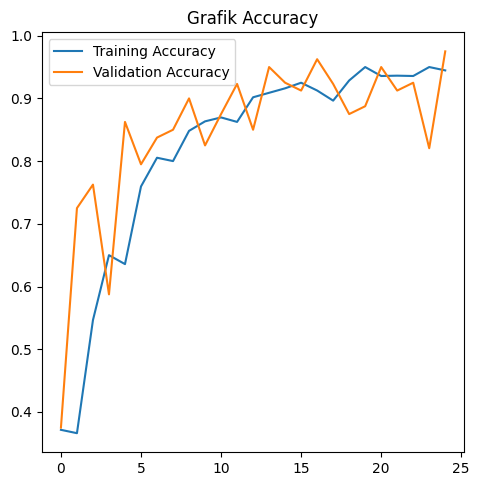

In [15]:
epochs_range = range(25)
# show accuracy in graphic form
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 3)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Grafik Accuracy')
plt.show()

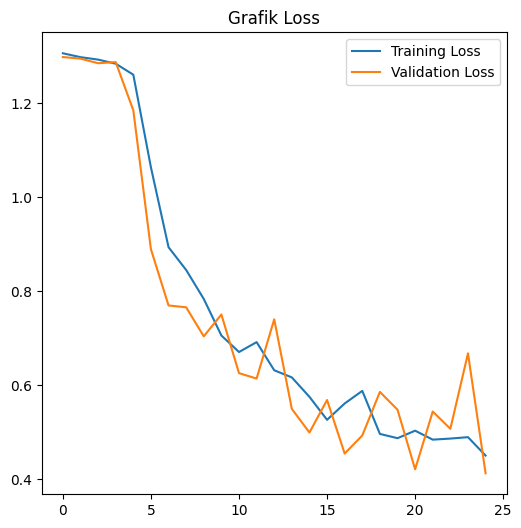

In [16]:
# show loss in graphic form
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Grafik Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


File test.jpg merupakan gambar:
paper


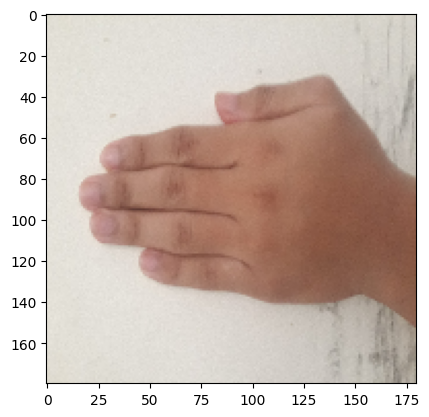

In [17]:
%matplotlib inline
 
# predict the image
path = 'test.jpg' # file name and path
img = image.load_img(path, target_size=(180,180))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)

print("\n")
print("File", path, "merupakan gambar:")
if classes[0][0]==1:
  print("paper")
elif classes[0][1]==1:
  print("rock")
else:
  print("scissors")